# Implementing Custom GridSearchCV without scikit-learn

Scikit-Learn offers two vehicles for optimizing hyperparameter tuning: GridSearchCV and RandomizedSearchCV.

**GridSearchCV** performs an exhaustive search over specified parameter values for an estimator (or machine learning algorithm) and returns the best performing hyperparametric combination.
So, all we need to do is specify the hyperparameters with which we want to
experiment and their range of values, and GridSearchCV performs all possible
combinations of hyperparameter values using cross-validation. As such, we naturally limit our choice of hyperparameters and their range of values. Theoretically, we can specify a set of parameter values for ALL hyperparameters of a model, but such a search consumes vast computer resources and time.

**RandomizedSearchCV** evaluates based on a predetermined subset of hyperparameters, randomly selects a chosen number of hyperparametric pairs from a given domain, and tests only those selected. RandomizedSearchCV tends to be less computationally expensive and time consuming because it doesn’t evaluate every possible hyperparametric combination. This method greatly simplifies analysis without significantly sacrificing optimization. RandomizedSearchCV is often an excellent choice for high-dimensional data as it returns a good hyperparametric combination very quickly.

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances


x,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)

X_train, X_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)

print('X_train shape ', X_train.shape)
print('X_test shape ', X_test.shape)

# del X_train,X_test

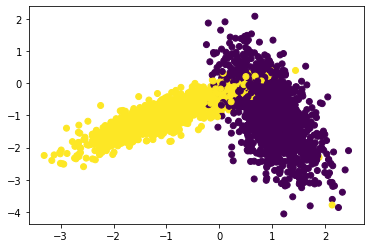

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
#colors = {0:'orange', 1:'blue'}
plt.scatter(X_test[:,0], X_test[:,1],c=y_test)
plt.show()

# Implementing Custom GridSearchCV

In [18]:
# it will take classifier and set of values for hyper prameter in dict type dict({hyper parmeter: [list of values]})
# we are implementing this only for KNN, hence the hyper parameter should be n_neighbors
from sklearn.metrics import accuracy_score
def randomly_select_60_percent_indices_in_range_from_1_to_len(x_train):
    return random.sample(range(0, len(x_train)), int(0.6*len(x_train)))

def GridSearch(x_train,y_train,classifier, params, folds):
    trainscores = []
    testscores  = []    
    for k in tqdm(params['n_neighbors']):
        trainscores_folds = []
        testscores_folds  = []
        for j in range(0, folds):
            # check this out: https://stackoverflow.com/a/9755548/4084039
            train_indices = randomly_select_60_percent_indices_in_range_from_1_to_len(x_train)
            test_indices  = list(set(list(range(1, len(x_train)))) - set(train_indices))

            # selecting the data points based on the train_indices and test_indices
            X_train = x_train[train_indices]
            Y_train = y_train[train_indices]
            X_test  = x_train[test_indices]
            Y_test  = y_train[test_indices]

            classifier.n_neighbors = k
            classifier.fit(X_train,Y_train)

            Y_predicted = classifier.predict(X_test)
            testscores_folds.append(accuracy_score(Y_test, Y_predicted))

            Y_predicted = classifier.predict(X_train)
            trainscores_folds.append(accuracy_score(Y_train, Y_predicted))
        trainscores.append(np.mean(np.array(trainscores_folds)))
        testscores.append(np.mean(np.array(testscores_folds)))
    return trainscores,testscores

Generally speaking, the "best" combination of hyperparameters is that with the highest average testing score. This
is an estimation of how well the model, fit using these hyperparameters, could perform when scored on new data.

Let's make a plot showing how the average testing and Training accuracy varies with the 'n_neighbors' hyperparameter.


100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


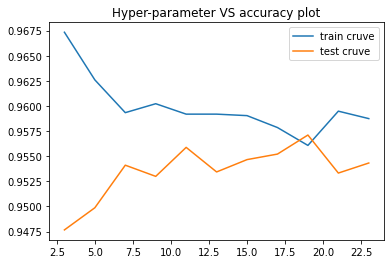

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")


neigh = KNeighborsClassifier()

params = {'n_neighbors':[3,5,7,9,11,13,15,17,19,21,23]}
folds = 3

trainscores,testscores = GridSearch(X_train, y_train, neigh, params, folds)
 

plt.plot(params['n_neighbors'],trainscores, label='train cruve')
plt.plot(params['n_neighbors'],testscores, label='test cruve')
plt.title('Hyper-parameter VS accuracy plot')
plt.legend()
plt.show()

In [20]:
# understanding this code line by line is not that importent 
def plot_decision_boundary(X1, X2, y, clf):
        # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()

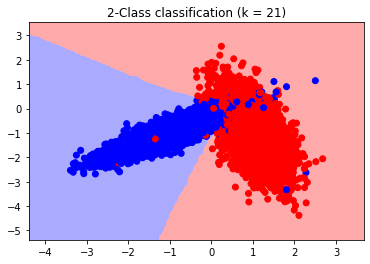

In [21]:
from matplotlib.colors import ListedColormap
neigh = KNeighborsClassifier(n_neighbors = 21)
neigh.fit(X_train, y_train)
plot_decision_boundary(X_train[:, 0], X_train[:, 1], y_train, neigh)